For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

- SAT scores by school - SAT scores for each high school in New York City
- School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

# Read in the data

In [21]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("/Users/kitaeklee/Desktop/Data Projects/coursera proejcts/Coursera Project 4 - High School/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [22]:
all_survey = pd.read_csv("/Users/kitaeklee/Desktop/Data Projects/coursera proejcts/Coursera Project 4 - High School/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("/Users/kitaeklee/Desktop/Data Projects/coursera proejcts/Coursera Project 4 - High School/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [24]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [25]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [26]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [27]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [28]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [29]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [30]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [31]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Correlation between SAT score and Survey Fields

There are several fields in 'combined' that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score

In [41]:
corr_survey = combined.corr()
corr_survey = corr_survey[survey_fields]
corr_survey = corr_survey.loc['sat_score', :]
corr_survey

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

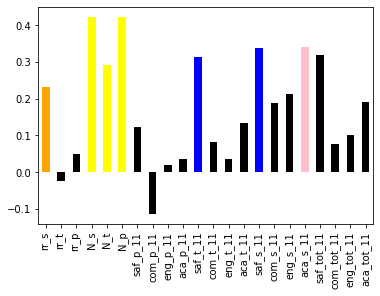

In [62]:
colors=['orange', 'black', 'black', 'yellow', 'yellow', 'yellow', 'black',
       'black', 'black', 'black', 'blue', 'black', 'black', 'black',
       'blue', 'black', 'black', 'pink', 'black', 'black', 'black', 'black']
corr_survey.plot(kind='bar', color=colors)
plt.show()

There are high correlations between 'N_s', 'N_t', 'N_p' and 'sat_score'. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that 'rr_s', the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety ('saf_t_11' and 'saf_s_11') correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the 'aca_s_11', which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# How teachers and students perceive safety at school

'saf_t_11' and 'saf_s_11', which measure how teachers and students perceive safety at school, correlated highly with 'sat_score'.

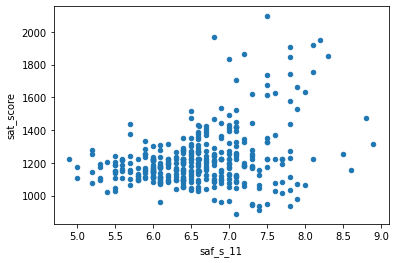

In [68]:
combined.plot(kind='scatter', y='sat_score', x='saf_s_11')

There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

# Average safe score for each Borough

In [88]:
boro_grouped = combined.groupby(by='boro').mean()
boro_grouped = boro_grouped['saf_s_11']
boro_grouped = pd.DataFrame(boro_grouped)
boro_grouped


,saf_s_11
boro,
Bronx,6.606577
Brooklyn,6.370755
Manhattan,6.831370
Queens,6.721875
Staten Island,6.530000


It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

# Racial differences in SAT Scores

There are a few columns that indicate the percentage of each race at a given school:
- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

- Make a bar plot of the correlations between the columns above and sat_score.

In [137]:
race_grouped = combined[['sat_score', 'white_per', 'asian_per',
                        'black_per', 'hispanic_per']].corr()
race_grouped = race_grouped.loc['sat_score', ['white_per', 'asian_per',
                                    'black_per', 'hispanic_per']]

In [138]:
race_grouped

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

Text(0.5, 0, 'Race')

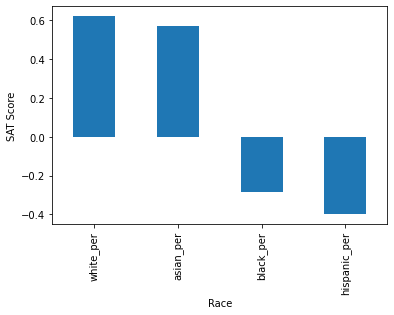

In [142]:
race_grouped.plot(kind='bar')
plt.ylabel('SAT Score')
plt.xlabel('Race')


It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

- Explore schools with low SAT scores and high values for hispanic_per. 

Make a scatter plot of hispanic_per vs. sat_score.

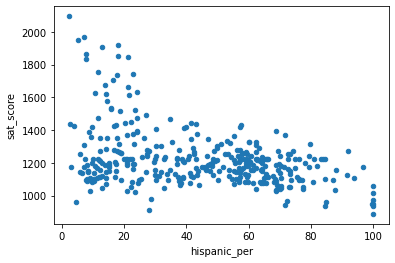

In [143]:
combined.plot(kind='scatter', y='sat_score', x='hispanic_per')

--> SAT score decreases as percentage of hispanic students increases.

- Research any schools with a hispanic_per greater than 95%.

In [148]:
print(combined['SCHOOL NAME'][combined['hispanic_per'] > 95])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.



- Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.

In [155]:
print(combined['SCHOOL NAME'][(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)])


37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object



Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Gender differences in SAT Scores

There are two columns that indicate the percentage of each gender at a school:

- male_per
- female_per

We can plot out the correlations between each percentage and sat_score.

Investigate gender differences in SAT scores.
- Make a bar plot of the correlations between the columns above and sat_score.

In [166]:
gender_corr = combined[['sat_score', 'male_per', 'female_per']].corr()
gender_corr = gender_corr.loc['sat_score',['male_per', 'female_per']]
gender_corr


male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

Text(0, 0.5, 'SAT Score')

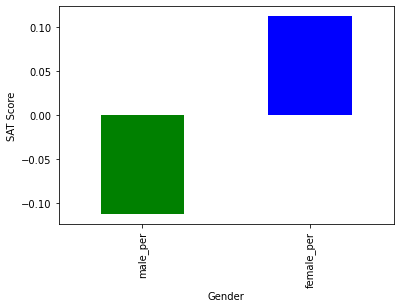

In [172]:
color2 = ['green', 'blue']
gender_corr.plot(kind='bar', color=color2)
plt.xlabel('Gender')
plt.ylabel('SAT Score')

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

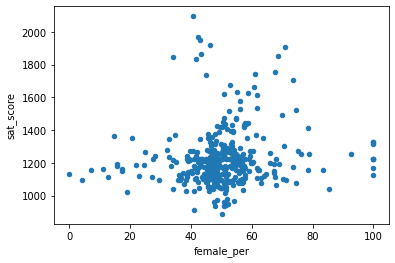

In [175]:
combined.plot(kind='scatter', x='female_per', y='sat_score')

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

- Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.


In [177]:
print(combined['SCHOOL NAME'][(combined['female_per'] > 60) & (combined['sat_score'] > 1700)])


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

- Calculate the percentage of students in each school that took an AP exam.

In [179]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

Investigate the relationship between AP scores and SAT scores.

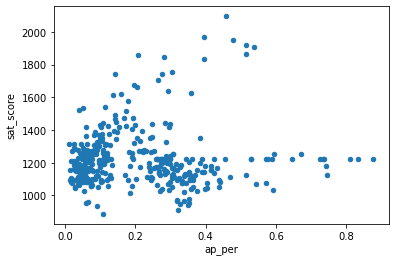

In [186]:
combined.plot(kind='scatter', y='sat_score', x='ap_per')

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.